In [ ]:
import random
import tensorflow as tf
import numpy as np
from collections import deque

In [1]:
from collections import deque
import random
import tensorflow as tf
import numpy as np


import random
import tensorflow as tf
import numpy as np

class Agent:
    def __init__(self, state_size, window_size, trend, skip, batch_size, volume, day_of_week,dayofyear,EMA_20,MACD,Signal_Line):
        self.volume = volume
        self.day_of_week = day_of_week

        self.dayofyear = dayofyear
        self.EMA_20 = EMA_20
        self.MACD = MACD
        self.Signal_Line = Signal_Line


        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen=batch_size)
        self.inventory = []

        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999** 16

        self.model = self.build_model()

    def build_model(self):
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(32, activation='relu', input_shape=(self.state_size,)),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(self.action_size)
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.767), loss='mean_squared_error')
        return model

    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return np.argmax(self.model.predict(state.reshape(1, self.state_size),verbose = 0)[0])
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        block_volume = self.volume[d : t] if d >= 0 else -d * [self.volume[0]] + self.volume[0 : t]  # adjusted slicing
        block_day_of_week = self.day_of_week[d : t] if d >= 0 else -d * [self.day_of_week[0]] + self.day_of_week[0 : t]  # adjusted slicing

        block_dayofyear = self.dayofyear[d : t] if d >= 0 else -d * [self.dayofyear[0]] + self.dayofyear[0 : t]  # adjusted slicing
        block_EMA_20 = self.EMA_20[d : t] if d >= 0 else -d * [self.EMA_20[0]] + self.EMA_20[0 : t]  # adjusted slicing
        block_MACD = self.MACD[d : t] if d >= 0 else -d * [self.MACD[0]] + self.MACD[0 : t]  # adjusted slicing
        block_Signal_Line= self.Signal_Line[d : t] if d >= 0 else -d * [self.Signal_Line[0]] + self.Signal_Line[0 : t]  # adjusted slicing

        res = np.concatenate((np.diff(block), block_volume, block_day_of_week,block_dayofyear,block_EMA_20,block_MACD,block_Signal_Line), axis=None)
        return np.array([res])

    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)

            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f' % (t, self.trend[t], initial_money))

            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print('day %d, sell 1 unit at price %f, investment %f %%, total balance %f,' %
                      (t, close[t], invest, initial_money))

            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest

    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)

                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]

                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]

                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest, next_state, starting_money < initial_money))
                state = next_state
                if len(self.memory) > self.batch_size:
                    self.replay(self.batch_size)
            if (i + 1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, total money: %f,epsilon%f' % (i + 1, total_profit, starting_money,self.epsilon))


C:\Users\User\anaconda3\envs\models_checking\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.12.2 when it was built against 1.12.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [5]:
import pandas as pd
data_lkoh = pd.read_parquet('data/data_lkoh.parquet')

head = 400
split = 0.5
initial_money = 10000
window_size = 64
skip = 4
batch_size = 32 
df = data_lkoh.copy()
data_100 = df.head(head)

name = 'Q-learning agent'
data_100 = data_100.sort_index(ascending=False)
data_100 = data_100.reset_index(drop=True)
# Assuming df is your DataFrame and 'Цена' is your target column
data = data_100['Цена'].values.tolist()
volume = data_100.Объём.values.tolist()
day_of_week = data_100.dayofweek.values.tolist()  # assuming you have a column named 'DayOfWeek'

dayofyear = data_100.dayofyear.values.tolist()  # assuming you have a column named 'dayofyear'
EMA_20 = data_100.EMA_20.values.tolist()  # assuming you have a column named 'DayOfWeek'
MACD = data_100.MACD.values.tolist()  # assuming you have a column named 'DayOfWeek'
Signal_Line = data_100.Signal_Line.values.tolist()  # assuming you have a column named 'DayOfWeek'
# Define the size of the training set. For example, 80% for training, 20% for testing.
train_size = int(len(data) * split)

# Split the data
train_data = data[:train_size]
test_data = data[train_size:]
# Train the agent with the training data
close = data_100.Цена.values.tolist()[:train_size]

agent = Agent(state_size = window_size * 7,  # updated state_size
              window_size = window_size,
              trend = train_data,
              skip = skip,
              batch_size = batch_size,
              volume = volume[:train_size],
              day_of_week = day_of_week[:train_size],
              dayofyear = dayofyear[:train_size],
              EMA_20 = EMA_20[:train_size],
              MACD = MACD[:train_size],
              Signal_Line = Signal_Line[:train_size],
              )

TypeError: __init__() got an unexpected keyword argument 'volume'

In [2]:

agent.train(iterations = 400, checkpoint = 5, initial_money = initial_money)

epoch: 5, total rewards: 227.000000.3, total money: 7274.000000,epsilon0.500000
epoch: 10, total rewards: 99.000000.3, total money: 4440.000000,epsilon0.500000



KeyboardInterrupt



In [15]:
states_buy_train, states_sell_train, total_gains_train, invest_train = agent.buy(initial_money = initial_money)
# Update the trend, volume, day_of_week, dayofyear, EMA_20, MACD, and Signal_Line of the agent with the test data
agent.trend = test_data
agent.volume = volume[train_size:]
agent.day_of_week = day_of_week[train_size:]
agent.dayofyear = dayofyear[train_size:]
agent.EMA_20 = EMA_20[train_size:]
agent.MACD = MACD[train_size:]
agent.Signal_Line = Signal_Line[train_size:]


close = data_100.Цена.values.tolist()[train_size:]

states_buy_test, states_sell_test, total_gains_test, invest_test = agent.buy(initial_money = initial_money)

day 0: buy 1 unit at price 1390.000000, total balance 8610.000000
day 4: buy 1 unit at price 1493.000000, total balance 7117.000000
day 12: buy 1 unit at price 1503.000000, total balance 5614.000000
day 16, sell 1 unit at price 1503.000000, investment 8.129496 %, total balance 7117.000000,
day 20, sell 1 unit at price 1483.000000, investment -0.669792 %, total balance 8600.000000,
day 24, sell 1 unit at price 1448.000000, investment -3.659348 %, total balance 10048.000000,
day 36: buy 1 unit at price 1407.000000, total balance 8641.000000
day 40: buy 1 unit at price 1483.000000, total balance 7158.000000
day 44: buy 1 unit at price 1492.000000, total balance 5666.000000
day 56: buy 1 unit at price 1594.000000, total balance 4072.000000
day 60: buy 1 unit at price 1649.000000, total balance 2423.000000
day 64: buy 1 unit at price 1609.000000, total balance 814.000000
day 72, sell 1 unit at price 1688.000000, investment 19.971571 %, total balance 2502.000000,
day 80, sell 1 unit at price

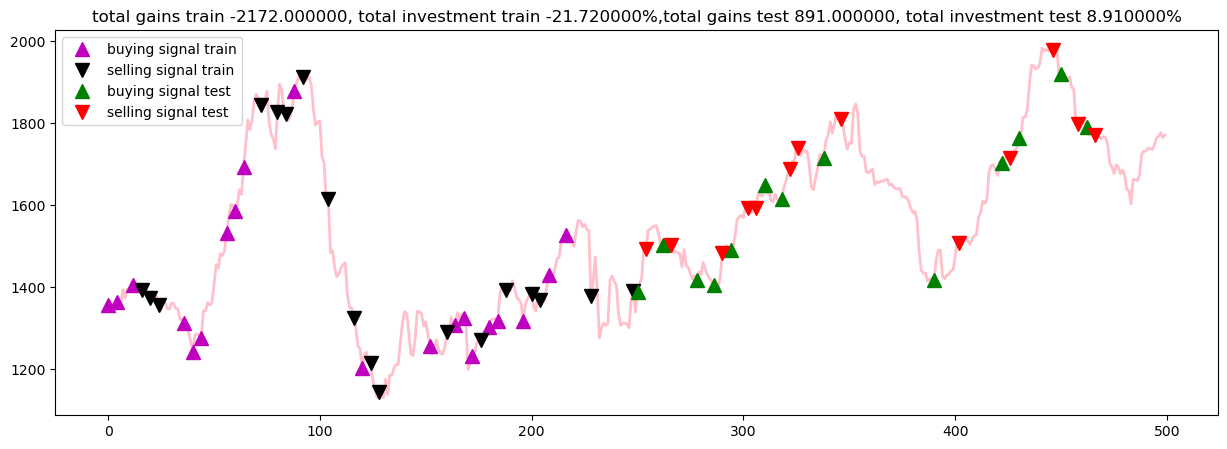

In [16]:

import numpy as np
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (15,5))
plt.plot(data, color='pink', lw=2.)
plt.plot(data, '^', markersize=10, color='m', label = 'buying signal train', markevery = states_buy_train)
plt.plot(data, 'v', markersize=10, color='k', label = 'selling signal train', markevery = states_sell_train)
states_buy_test_scaled = [x + int(head*split) for x in states_buy_test]
states_sell_test_scaled = [x + int(head*split) for x in states_sell_test]

plt.plot(data, '^', markersize=10, color='green', label = 'buying signal test', markevery = states_buy_test_scaled)
plt.plot(data, 'v', markersize=10, color='red', label = 'selling signal test', markevery = states_sell_test_scaled)


plt.title('total gains train %f, total investment train %f%%,total gains test %f, total investment test %f%%'%(total_gains_train, invest_train,total_gains_test, invest_test))
plt.legend()
plt.show()

In [79]:
import tensorflow as tf
from collections import deque
import random
import numpy as np

class Agent:
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000)
        self.inventory = []

        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999

        self.model = self._build_model()

    def _build_model(self):
        model = tf.keras.models.Sequential()
        model.add(tf.keras.layers.Dense(32, input_dim=self.state_size, activation='relu'))
        model.add(tf.keras.layers.Dense(256,activation='relu'))
        model.add(tf.keras.layers.Dense(128,activation='relu'))
        model.add(tf.keras.layers.Dense(self.action_size, activation='relu'))
        model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.1))
        return model

    def act(self, state):
        state = tf.reshape(state, (1, -1))  # Reshape state to match expected input shape
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.model.output_shape[-1])
        else:
            act_values = self.model(state, training=False)
            return tf.argmax(act_values[0])


    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def replay(self, batch_size):
        mini_batch = random.sample(self.memory, batch_size)
        states = np.zeros((batch_size, self.state_size))
        targets = np.zeros((batch_size, self.action_size))
        for i, (state, action, reward, next_state, done) in enumerate(mini_batch):
            states[i] = state
            target = reward
            if not done:
                target = (reward + self.gamma * np.amax(self.model(next_state.reshape(1, -1))[0]))
            targets[i] = self.model(state.reshape(1, -1))
            targets[i][action] = target
        dataset = tf.data.Dataset.from_tensor_slices((states, targets)).batch(batch_size)
        for batch in dataset:
            self.model.train_on_batch(*batch)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)

            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))

            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )

            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest

    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0.0
            inventory = []
            state = self.get_state(0)
            starting_money = tf.cast(initial_money, tf.float32)  # Ensure starting_money is a float
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state[0])  # Reshape state to match expected input shape
                next_state = self.get_state(t + 1)

                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]

                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]

                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest,
                                    next_state, starting_money < initial_money))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                self.replay(batch_size)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, total money: %f,epsilon%f'%(i + 1, total_profit, starting_money,self.epsilon))

In [80]:
data_lkoh = pd.read_parquet('data/data_lkoh.parquet')
close = df.head(500).Цена.values.tolist()


In [82]:
initial_money = 10000
window_size = 64
skip = 2
batch_size = 16
agent = Agent(state_size = window_size,
              window_size = window_size,
              trend = close,
              skip = skip,
              batch_size = batch_size)
agent.train(iterations = 55, checkpoint = 1, initial_money = initial_money)

epoch: 1, total rewards: -1275.000000.3, total money: 7378.000000,epsilon0.389352
epoch: 2, total rewards: -2652.000000.3, total money: 7348.000000,epsilon0.303189
epoch: 3, total rewards: -2003.000000.3, total money: 6212.000000,epsilon0.236095
epoch: 4, total rewards: 271.000000.3, total money: 10271.000000,epsilon0.183848
epoch: 5, total rewards: -48.000000.3, total money: 8094.000000,epsilon0.143163
epoch: 6, total rewards: 178.000000.3, total money: 7480.000000,epsilon0.111481
epoch: 7, total rewards: -1318.000000.3, total money: 5511.000000,epsilon0.086811
epoch: 8, total rewards: -840.000000.3, total money: 7845.000000,epsilon0.067600
epoch: 9, total rewards: -244.000000.3, total money: 3322.000000,epsilon0.052640


KeyboardInterrupt: 

In [ ]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)